In [357]:
from sklearn.neighbors import KNeighborsTransformer
import joblib
import palantir

In [273]:

def weighted_knn_trainer(train_adata, train_adata_emb, label_key, n_neighbors=50):
    """Trains a weighted KNN classifier on ``train_adata``.
    Parameters
    ----------
    train_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to train KNN classifier with ``label_key`` as the target variable.
    train_adata_emb: str
        Name of the obsm layer to be used for calculation of neighbors. If set to "X", anndata.X will be
        used
    label_key: str
        Name of the column to be used as target variable (e.g. cell_type) in ``train_adata`` and ``query_adata``.
    n_neighbors: int
        Number of nearest neighbors in KNN classifier.
    """
    print(
        f"Weighted KNN with n_neighbors = {n_neighbors} ... ",
        end="",
    )
    k_neighbors_transformer = KNeighborsTransformer(
        n_neighbors=n_neighbors,
        mode="distance",
        algorithm="brute",
        metric="euclidean",
        n_jobs=-1,
    )
    if train_adata_emb == "X":
        train_emb = train_adata.X
    elif train_adata_emb in train_adata.obsm.keys():
        train_emb = train_adata.obsm[train_adata_emb]
    else:
        raise ValueError(
            "train_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    k_neighbors_transformer.fit(train_emb)
    return k_neighbors_transformer


def weighted_knn_transfer(
    query_adata,
    query_adata_emb,
    ref_adata_obs,
    label_keys,
    knn_model,
    threshold=1,
    pred_unknown=False,
    mode="package",
):
    """Annotates ``query_adata`` cells with an input trained weighted KNN classifier.
    Parameters
    ----------
    query_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to queryate KNN classifier. Embedding to be used
    query_adata_emb: str
        Name of the obsm layer to be used for label transfer. If set to "X",
        query_adata.X will be used
    ref_adata_obs: :class:`pd.DataFrame`
        obs of ref Anndata
    label_keys: str
        Names of the columns to be used as target variables (e.g. cell_type) in ``query_adata``.
    knn_model: :class:`~sklearn.neighbors._graph.KNeighborsTransformer`
        knn model trained on reference adata with weighted_knn_trainer function
    threshold: float
        Threshold of uncertainty used to annotating cells as "Unknown". cells with
        uncertainties higher than this value will be annotated as "Unknown".
        Set to 1 to keep all predictions. This enables one to later on play
        with thresholds.
    pred_unknown: bool
        ``False`` by default. Whether to annotate any cell as "unknown" or not.
        If `False`, ``threshold`` will not be used and each cell will be annotated
        with the label which is the most common in its ``n_neighbors`` nearest cells.
    mode: str
        Has to be one of "paper" or "package". If mode is set to "package",
        uncertainties will be 1 - P(pred_label), otherwise it will be 1 - P(true_label).
    """
    if not type(knn_model) == KNeighborsTransformer:
        raise ValueError(
            "knn_model should be of type sklearn.neighbors._graph.KNeighborsTransformer!"
        )

    if query_adata_emb == "X":
        query_emb = query_adata.X
    elif query_adata_emb in query_adata.obsm.keys():
        query_emb = query_adata.obsm[query_adata_emb]
    else:
        raise ValueError(
            "query_adata_emb should be set to either 'X' or the name of the obsm layer to be used!"
        )
    top_k_distances, top_k_indices = knn_model.kneighbors(X=query_emb)

    stds = np.std(top_k_distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)

    top_k_distances_tilda = np.exp(-np.true_divide(top_k_distances, stds))

    weights = top_k_distances_tilda / np.sum(
        top_k_distances_tilda, axis=1, keepdims=True
    )
    cols = ref_adata_obs.columns[ref_adata_obs.columns.str.startswith(label_keys)]
    uncertainties = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    pred_labels = pd.DataFrame(columns=cols, index=query_adata.obs_names)
    for i in range(len(weights)):
        for j in cols:
            y_train_labels = ref_adata_obs[j].values
            unique_labels = np.unique(y_train_labels[top_k_indices[i]])
            best_label, best_prob = None, 0.0
            for candidate_label in unique_labels:
                candidate_prob = weights[
                    i, y_train_labels[top_k_indices[i]] == candidate_label
                ].sum()
                if best_prob < candidate_prob:
                    best_prob = candidate_prob
                    best_label = candidate_label

            if pred_unknown:
                if best_prob >= threshold:
                    pred_label = best_label
                else:
                    pred_label = "Unknown"
            else:
                pred_label = best_label

            if mode == "package":
                uncertainties.iloc[i][j] = (max(1 - best_prob, 0))

            else:
                raise Exception("Inquery Mode!")

            pred_labels.iloc[i][j] = (pred_label)

    print("finished!")

    return pred_labels, uncertainties

In [270]:
trainLatent.obs.columns.str

In [272]:
trainLatent.obs.columns.str.startswith("lineage")

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True])

In [212]:
trainLatent=sc.read("../../important_processed_data/4.17_wt_integrate_SCRAN_log1p_scANVI.h5ad")

In [300]:
trainLatent

AnnData object with n_obs × n_vars = 273479 × 62934
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Cre', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'K2', 'K6', 'K12', 'K24', 'K53', 'K2.1', 'K6.1', 'K12.1', 'K24.1', 'K53.1', 'K2.2', 'K6.2', 'K12.2', 'K24.2', 'K53.2', 'K2.3', 'K6.3', 'K12.3', 'K24.3', 'K53.3', 'C2', 'C6', 'C12', 'C21', 'C41', 'C2_named', 'C6_named', 'C12_named', 'C21_named', 'C41_named', 'K4', 'K11', 'K25', 'K57', 'C4', 'C9', 'C22', 'C42', 'C4_named', 'C9_named', 'C22_named', 'C42_named', 'K5', 'K19', 'K65', 'C17', 'C36', 'C5', 'C5_named', 'C17_named', 'C36_named', 'batch_atlas', 'size_factors', 'n_genes_by_cou

In [241]:
lineageInfer=pd.read_csv("../../important_processed_data/11.2_dpt_lineage_infer.csv",index_col=0)

In [240]:
lineageInfer2.index

Index(['Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGATGAGGGAACGG-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGTAGTCGGAGCAA-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGTAGTCTAACTTC-1_1-0_1_1',
       'Suture2021_Farmer_E17_AACACGTGTTGTGGAG-1_1-0_1_1',
       'Suture2021_Farmer_E17_AACACGTTCGTAGATC-1_1-0_1_1',
       'Suture2021_Farmer_E17_AACCATGTCCGCAAGC-1_1-0_1_1',
       'Suture2021_Farmer_E17_AACCGCGCACCAGCAC-1_1-0_1_1',
       ...
       'TTTCAGTAGAAGTCCG-1_5-1-2_1_1', 'TTTCAGTAGGTAGTCG-1_5-1-2_1_1',
       'TTTCCTCGTTGTGGCC-1_5-1-2_1_1', 'TTTCGATTCCTCTAAT-1_5-1-2_1_1',
       'TTTCGATTCTGGTGCG-1_5-1-2_1_1', 'TTTGACTGTATTTCCT-1_5-1-2_1_1',
       'TTTGACTGTTGCATTG-1_5-1-2_1_1', 'TTTGACTTCTTGGGCG-1_5-1-2_1_1',
       'TTTGGAGCAGCGACAA-1_5-1-2_1_1', 'TTTGGTTCACTACTTT-1_5-1-2_1_1'],
      dtype='object', length=166204)

In [239]:
trainLatent.obs_names

Index(['Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0',
       'Suture2021_Farmer_E17_AAACCTGGTGCGGTAA-1_1-0',
       'Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0',
       'Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0',
       'Suture2021_Farmer_E17_AAACCTGTCGTTACGA-1_1-0',
       'Suture2021_Farmer_E17_AAAGATGAGGGAACGG-1_1-0',
       'Suture2021_Farmer_E17_AAAGTAGAGGAATGGA-1_1-0',
       'Suture2021_Farmer_E17_AAAGTAGCAGCTATTG-1_1-0',
       'Suture2021_Farmer_E17_AAAGTAGTCAATCACG-1_1-0',
       'Suture2021_Farmer_E17_AAAGTAGTCGGAGCAA-1_1-0',
       ...
       'TTTCAGTAGAAGTCCG-1_5-1-2', 'TTTCAGTAGGTAGTCG-1_5-1-2',
       'TTTCCTCGTTGTGGCC-1_5-1-2', 'TTTCGATTCCTCTAAT-1_5-1-2',
       'TTTCGATTCTGGTGCG-1_5-1-2', 'TTTGACTGTATTTCCT-1_5-1-2',
       'TTTGACTGTTGCATTG-1_5-1-2', 'TTTGACTTCTTGGGCG-1_5-1-2',
       'TTTGGAGCAGCGACAA-1_5-1-2', 'TTTGGTTCACTACTTT-1_5-1-2'],
      dtype='object', length=273479)

In [263]:
train_logic= [s in lineageInfer.index for s in trainLatent.obs_names]
trainLatent.obs["lineage_laFibro"]=False
trainLatent.obs["lineage_lepr"]=False
trainLatent.obs["lineage_mesenchyme"]=False
trainLatent.obs["lineage_chondro"]=False
trainLatent.obs["lineage_chondro"][np.array(train_logic)]=np.array(lineageInfer2["lineage_chondro"])
trainLatent.obs["lineage_laFibro"][np.array(train_logic)]=np.array(lineageInfer2["lineage_laFibro"])
trainLatent.obs["lineage_lepr"][np.array(train_logic)]=np.array(lineageInfer2["lineage_lepr"])
trainLatent.obs["lineage_mesenchyme"][np.array(train_logic)]=np.array(lineageInfer2["lineage_mesenchyme"])

/tmp/ipykernel_1921307/720715721.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainLatent.obs["lineage_chondro"][np.array(train_logic)]=np.array(lineageInfer2["lineage_chondro"])
/tmp/ipykernel_1921307/720715721.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainLatent.obs["lineage_laFibro"][np.array(train_logic)]=np.array(lineageInfer2["lineage_laFibro"])
/tmp/ipykernel_1921307/720715721.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [280]:
k_neighbors_transformer = weighted_knn_trainer(
        train_adata=trainLatent,
        train_adata_emb="X_scANVI",
        label_key="lineage",
        n_neighbors=50,
    )

Weighted KNN with n_neighbors = 50 ... 

In [309]:
trainLatent.obsm["X_scANVI"][1:10,1:10]

array([[ 1.542232  , -0.20840882,  0.6338593 ,  0.3691453 ,  0.0721021 ,
         0.61593556, -1.1624895 , -1.3450018 , -0.3077996 ],
       [-1.515867  , -0.9800684 ,  0.7278477 ,  0.69423354, -1.32781   ,
        -0.42745012,  0.15492007,  0.43651474, -1.6776227 ],
       [-1.7600436 , -0.6657913 ,  0.25014976,  1.4271581 , -0.86021024,
        -0.21531877, -0.7646313 ,  1.2439418 , -1.3469551 ],
       [ 0.27158788, -1.2488928 ,  1.087083  , -1.1752266 , -0.5321611 ,
        -0.17696945, -0.46612984,  0.14604115,  1.8572199 ],
       [-1.2464025 ,  0.2933187 ,  0.58846223,  0.03772151, -0.17283359,
        -0.0643929 ,  0.5518029 , -0.33341432, -1.9083612 ],
       [ 0.7214164 ,  0.3552366 ,  0.87853765, -0.25584286,  2.8824437 ,
        -0.59514344,  0.00441497,  0.4490109 ,  0.1131882 ],
       [ 0.9051802 ,  0.04526833,  0.5910697 , -0.53915244, -0.6335223 ,
         0.8893539 ,  0.49104995,  0.45574814,  0.48621914],
       [ 0.8472681 , -0.5125905 ,  1.2026147 , -0.478624  , -1

In [312]:
trainLatent.obs_names

Index(['Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0',
       'Suture2021_Farmer_E17_AAACCTGGTGCGGTAA-1_1-0',
       'Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0',
       'Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0',
       'Suture2021_Farmer_E17_AAACCTGTCGTTACGA-1_1-0',
       'Suture2021_Farmer_E17_AAAGATGAGGGAACGG-1_1-0',
       'Suture2021_Farmer_E17_AAAGTAGAGGAATGGA-1_1-0',
       'Suture2021_Farmer_E17_AAAGTAGCAGCTATTG-1_1-0',
       'Suture2021_Farmer_E17_AAAGTAGTCAATCACG-1_1-0',
       'Suture2021_Farmer_E17_AAAGTAGTCGGAGCAA-1_1-0',
       ...
       'TTTCAGTAGAAGTCCG-1_5-1-2', 'TTTCAGTAGGTAGTCG-1_5-1-2',
       'TTTCCTCGTTGTGGCC-1_5-1-2', 'TTTCGATTCCTCTAAT-1_5-1-2',
       'TTTCGATTCTGGTGCG-1_5-1-2', 'TTTGACTGTATTTCCT-1_5-1-2',
       'TTTGACTGTTGCATTG-1_5-1-2', 'TTTGACTTCTTGGGCG-1_5-1-2',
       'TTTGGAGCAGCGACAA-1_5-1-2', 'TTTGGTTCACTACTTT-1_5-1-2'],
      dtype='object', length=273479)

In [313]:
extendAtlas.obs_names

Index(['Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAACCTGGTGCGGTAA-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAACCTGTCGTTACGA-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGATGAGGGAACGG-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGTAGAGGAATGGA-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGTAGCAGCTATTG-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGTAGTCAATCACG-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGTAGTCGGAGCAA-1_1-0_1_1',
       ...
       'TTTGGTTTCTCGCGTT-1_8', 'TTTGGTTTCTCTGAGA-1_8', 'TTTGTTGAGATAGTCA-1_8',
       'TTTGTTGAGCGGTAGT-1_8', 'TTTGTTGAGGAATGTT-1_8', 'TTTGTTGAGGTGATAT-1_8',
       'TTTGTTGAGTCTTCCC-1_8', 'TTTGTTGGTCCACACG-1_8', 'TTTGTTGTCACTACGA-1_8',
       'TTTGTTGTCCGGGACT-1_8'],
      dtype='object', length=781397)

In [311]:
extendAtlas.obsm["scANVI"][1:10,1:10]

array([[ 0.83082396, -1.5729802 , -0.64399886,  1.0862315 ,  0.7683903 ,
        -0.28897393, -1.745243  , -0.30053496,  0.92356765],
       [ 0.91781324, -1.1386579 , -0.11604328, -0.24407566,  0.9726689 ,
        -0.81006366,  2.1757264 ,  1.019171  ,  0.35743892],
       [ 0.8211469 , -1.4039313 , -0.20011805, -1.1779813 , -0.7435301 ,
        -0.5832182 ,  2.7687414 ,  0.54891   ,  0.29147667],
       [ 0.19015646,  0.18541196, -0.88879573, -0.55126643, -1.2109184 ,
        -0.9436684 , -1.5906427 ,  0.47121122,  0.1969156 ],
       [ 0.40051448, -1.0490718 , -0.62207556, -0.26404774,  1.380254  ,
         0.24652158,  1.6053985 ,  0.02474271,  0.23904932],
       [ 0.07648581,  0.60582393, -1.5732449 , -0.4767673 , -0.47325552,
         0.24127866, -0.3844737 , -0.5399778 ,  0.8473006 ],
       [ 0.2837426 ,  1.9716265 , -0.43725026, -0.751665  ,  0.15800019,
        -0.10813738, -1.2061986 , -0.6306435 ,  0.09617049],
       [-0.12424326,  0.9838454 , -0.8293383 , -1.0387464 , -0

In [306]:
k_neighbors_transformer

KNeighborsTransformer(algorithm='brute', metric='euclidean', n_jobs=-1,
                      n_neighbors=50)

In [277]:
extendAtlas

AnnData object with n_obs × n_vars = 781397 × 20664
    obs: 'Sample', 'Project', 'Core Dataset', 'Limb Atlas', 'Cranial Atlas', 'Organ', 'Tissue', 'Tissue(Specific)', 'Stage', 'Gene type', 'Treatment', 'Age', 'Age(In Detail)', 'Machine', 'Species', 'Isolation approach', 'Digestion', 'Enzymes', 'Cre', 'Bone Forming Methods', 'Data Source', 'Related Assay', 'Cell Count After QC', 'Origin', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'nCount_originalexp', 'nFeature_originalexp', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'batch', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'transf_ann_level_7_label', 'transf_ann_level_6_label', 'transf_ann_level_5_label', 'transf_ann_level_4_label', 'transf_ann_level_

In [285]:
labels, uncert = weighted_knn_transfer(
        query_adata=extendAtlas,
        query_adata_emb="scANVI",
        label_keys="lineage",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = trainLatent.obs
    )

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7eef480711f0>
Traceback (most recent call last):
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


finished!


In [367]:
labels.to_csv("../process_data/lineage/1.3_label.csv")
uncert.to_csv("../process_data/lineage/1.3_uncert.csv")

In [288]:
extendAtlas.obs["lineage_chondro"]=labels["lineage_chondro"]
extendAtlas.obs["lineage_laFibro"]=labels["lineage_laFibro"]
extendAtlas.obs["lineage_lepr"]=labels["lineage_lepr"]
extendAtlas.obs["lineage_mesenchyme"]=labels["lineage_mesenchyme"]

In [304]:
extendAtlas.obs["lineage_mesenchyme"]=extendAtlas.obs["lineage_mesenchyme"].astype("str")
extendAtlas.obs["lineage_laFibro"]=extendAtlas.obs["lineage_laFibro"].astype("str")
extendAtlas.obs["lineage_chondro"]=extendAtlas.obs["lineage_chondro"].astype("str")

/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


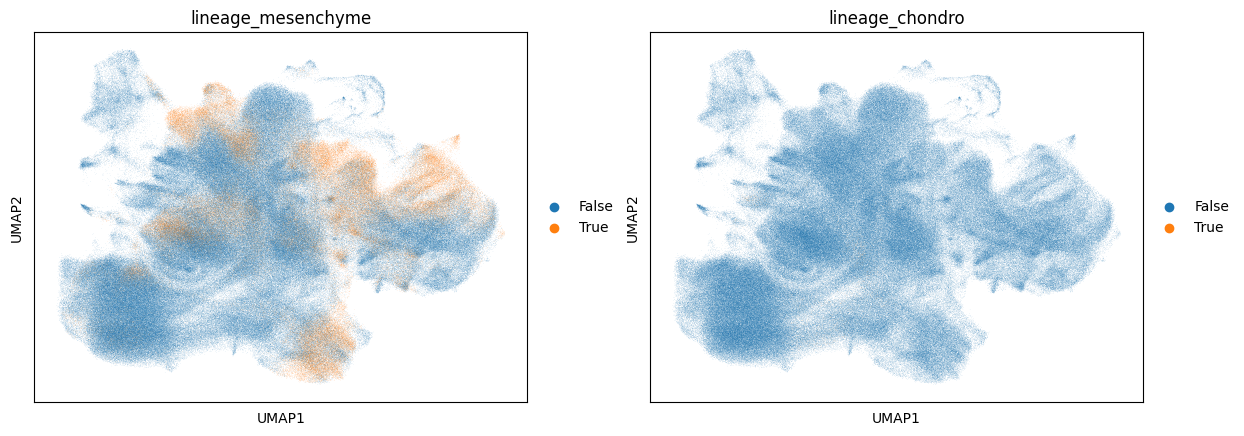

In [305]:
sc.pl.umap(extendAtlas,color=["lineage_mesenchyme","lineage_chondro"])

In [301]:
trainLatent.obs["lineage_mesenchyme"]=trainLatent.obs["lineage_mesenchyme"].astype("str")
trainLatent.obs["lineage_chondro"]=trainLatent.obs["lineage_chondro"].astype("str")

/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


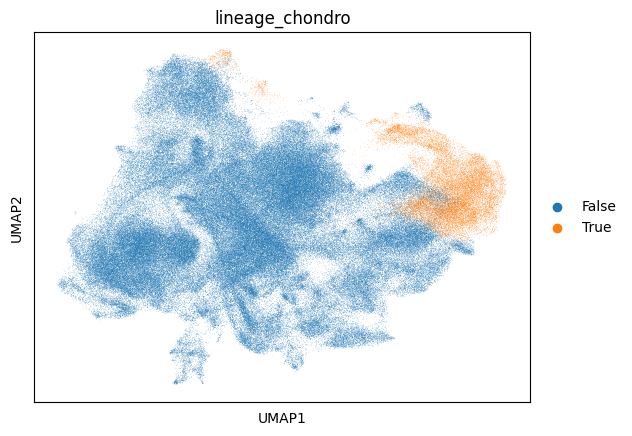

In [302]:
sc.pl.umap(trainLatent,color=["lineage_chondro"])

In [284]:
testlabels, testuncert = weighted_knn_transfer(
        query_adata=trainLatent[1:100],
        query_adata_emb="X_scANVI",
        label_keys="lineage",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = trainLatent.obs
    )

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7eef4842e160>
Traceback (most recent call last):
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


finished!


In [317]:
extendMeta=pd.read_csv("../../important_processed_data/9.20_intergrate_meta.csv",index_col=0)

/tmp/ipykernel_1921307/1508776214.py:1: DtypeWarning: Columns (16,17,18,19,21,22,28,29,30,31,57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  extendMeta=pd.read_csv("../../important_processed_data/9.20_intergrate_meta.csv",index_col=0)


In [321]:
reflatent3.obs["Core_or_Extand"]=extendMeta["Core_or_Extand"]

In [322]:
reflatent3.obs["Core_or_Extand"]

Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0_1_1      Core
Suture2021_Farmer_E17_AAACCTGGTGCGGTAA-1_1-0_1_1      Core
Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0_1_1      Core
Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0_1_1      Core
Suture2021_Farmer_E17_AAACCTGTCGTTACGA-1_1-0_1_1      Core
                                                     ...  
TTTGTTGAGGTGATAT-1_8                                Extand
TTTGTTGAGTCTTCCC-1_8                                Extand
TTTGTTGGTCCACACG-1_8                                Extand
TTTGTTGTCACTACGA-1_8                                Extand
TTTGTTGTCCGGGACT-1_8                                Extand
Name: Core_or_Extand, Length: 781397, dtype: object

In [323]:
trainLatent=reflatent3[reflatent3.obs["Core_or_Extand"]=="Core"]

In [326]:
lineageInfer2.index

Index(['Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGATGAGGGAACGG-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGTAGTCGGAGCAA-1_1-0_1_1',
       'Suture2021_Farmer_E17_AAAGTAGTCTAACTTC-1_1-0_1_1',
       'Suture2021_Farmer_E17_AACACGTGTTGTGGAG-1_1-0_1_1',
       'Suture2021_Farmer_E17_AACACGTTCGTAGATC-1_1-0_1_1',
       'Suture2021_Farmer_E17_AACCATGTCCGCAAGC-1_1-0_1_1',
       'Suture2021_Farmer_E17_AACCGCGCACCAGCAC-1_1-0_1_1',
       ...
       'TTTCAGTAGAAGTCCG-1_5-1-2_1_1', 'TTTCAGTAGGTAGTCG-1_5-1-2_1_1',
       'TTTCCTCGTTGTGGCC-1_5-1-2_1_1', 'TTTCGATTCCTCTAAT-1_5-1-2_1_1',
       'TTTCGATTCTGGTGCG-1_5-1-2_1_1', 'TTTGACTGTATTTCCT-1_5-1-2_1_1',
       'TTTGACTGTTGCATTG-1_5-1-2_1_1', 'TTTGACTTCTTGGGCG-1_5-1-2_1_1',
       'TTTGGAGCAGCGACAA-1_5-1-2_1_1', 'TTTGGTTCACTACTTT-1_5-1-2_1_1'],
      dtype='object', length=166204)

In [327]:
train_logic= [s in lineageInfer2.index for s in trainLatent.obs_names]
trainLatent.obs["lineage_laFibro"]=False
trainLatent.obs["lineage_lepr"]=False
trainLatent.obs["lineage_mesenchyme"]=False
trainLatent.obs["lineage_chondro"]=False
trainLatent.obs["lineage_chondro"][np.array(train_logic)]=np.array(lineageInfer2["lineage_chondro"])
trainLatent.obs["lineage_laFibro"][np.array(train_logic)]=np.array(lineageInfer2["lineage_laFibro"])
trainLatent.obs["lineage_lepr"][np.array(train_logic)]=np.array(lineageInfer2["lineage_lepr"])
trainLatent.obs["lineage_mesenchyme"][np.array(train_logic)]=np.array(lineageInfer2["lineage_mesenchyme"])

/tmp/ipykernel_1921307/2894022918.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  trainLatent.obs["lineage_laFibro"]=False
/tmp/ipykernel_1921307/2894022918.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainLatent.obs["lineage_chondro"][np.array(train_logic)]=np.array(lineageInfer2["lineage_chondro"])
/tmp/ipykernel_1921307/2894022918.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainLatent.obs["lineage_laFibro"][np.array(train_logic)]=np.array(lineageInfer2["lineage_laFibro"])
/tmp/ipykernel_1921307/2894022918.py:8: SettingWithCopyWarning: 
A v

In [331]:
trainLatent

AnnData object with n_obs × n_vars = 272369 × 15
    obs: 'Sample', 'Project', 'Core Dataset', 'Limb Atlas', 'Cranial Atlas', 'Organ', 'Tissue', 'Tissue(Specific)', 'Stage', 'Gene type', 'Treatment', 'Age', 'Age(In Detail)', 'Machine', 'Species', 'Isolation approach', 'Digestion', 'Enzymes', 'Cre', 'Bone Forming Methods', 'Data Source', 'Related Assay', 'Cell Count After QC', 'Origin', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'nCount_originalexp', 'nFeature_originalexp', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'batch', '_scvi_batch', 'scanvi_label', '_scvi_labels', 'leiden', 'pred_anno', 'reject', 'pred_anno7', 'pred_anno19', 'pred_anno36', 'pred_anno49', 'pred_anno90', 'leiden_clusters_0.001', 'leiden_clusters_0.005', 'leide

In [330]:
k_neighbors_transformer = weighted_knn_trainer(
        train_adata=trainLatent,
        train_adata_emb="X",
        label_key="lineage",
        n_neighbors=50,
    )

Weighted KNN with n_neighbors = 50 ... 

In [332]:
labels, uncert = weighted_knn_transfer(
        query_adata=extendAtlas,
        query_adata_emb="scANVI",
        label_keys="lineage",
        knn_model=k_neighbors_transformer,
        ref_adata_obs = trainLatent.obs
    )

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7eef23329dc0>
Traceback (most recent call last):
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


finished!


In [333]:
extendAtlas.obs["lineage_chondro"]=labels["lineage_chondro"]
extendAtlas.obs["lineage_laFibro"]=labels["lineage_laFibro"]
extendAtlas.obs["lineage_lepr"]=labels["lineage_lepr"]
extendAtlas.obs["lineage_mesenchyme"]=labels["lineage_mesenchyme"]

In [339]:
extendAtlas.obs["lineage_mesenchyme"]=extendAtlas.obs["lineage_mesenchyme"].astype("str")
extendAtlas.obs["lineage_laFibro"]=extendAtlas.obs["lineage_laFibro"].astype("str")
extendAtlas.obs["lineage_chondro"]=extendAtlas.obs["lineage_chondro"].astype("str")
extendAtlas.obs["lineage_lepr"]=extendAtlas.obs["lineage_lepr"].astype("str")

/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


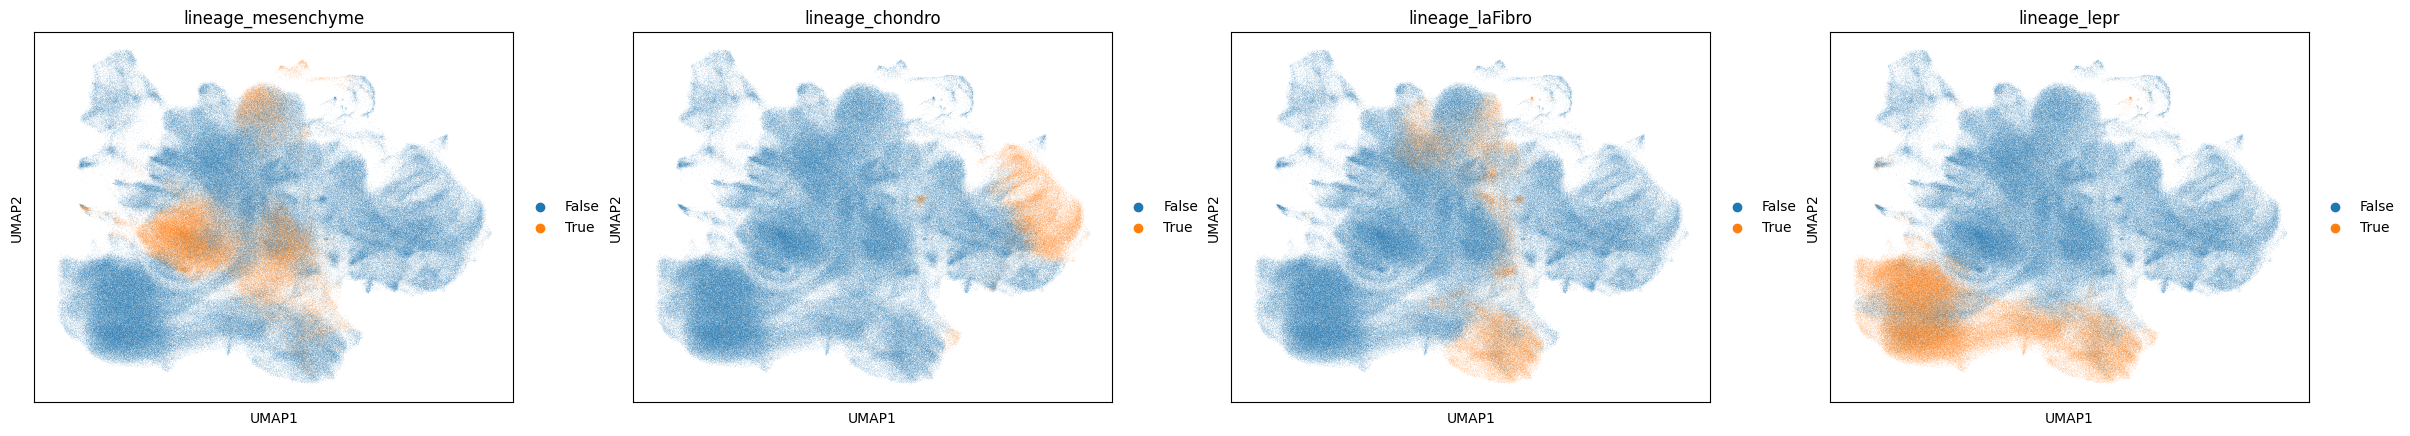

In [340]:
sc.pl.umap(extendAtlas,color=["lineage_mesenchyme","lineage_chondro","lineage_laFibro","lineage_lepr"])

In [347]:
dpt=pd.read_csv("../../important_processed_data/24.1.4_dpt.csv",index_col=0)

In [354]:
extendAtlas.obs["dpt_pred"]=np.array(dpt)

In [355]:
extendAtlas.obs["dpt_pred"]

Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0_1_1    0.185714
Suture2021_Farmer_E17_AAACCTGGTGCGGTAA-1_1-0_1_1    0.109794
Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0_1_1    0.482144
Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0_1_1    0.658415
Suture2021_Farmer_E17_AAACCTGTCGTTACGA-1_1-0_1_1    0.146896
                                                      ...   
TTTGTTGAGGTGATAT-1_8                                0.213042
TTTGTTGAGTCTTCCC-1_8                                0.298591
TTTGTTGGTCCACACG-1_8                                0.235161
TTTGTTGTCACTACGA-1_8                                0.226255
TTTGTTGTCCGGGACT-1_8                                0.161028
Name: dpt_pred, Length: 781397, dtype: float64

In [ ]:
sc.pl.umap(extendAtlas,color="C7_named")

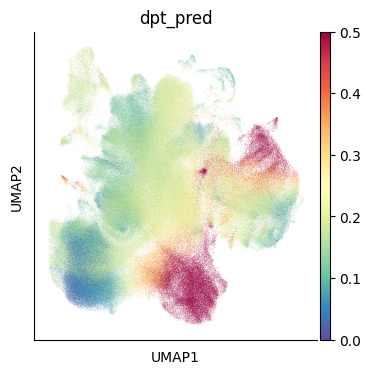

In [361]:
sc.pl.umap(extendAtlas,color="dpt_pred",vmax=0.5,vmin=0)

In [362]:
projectInfo=extendAtlas.obs["Project"]

In [364]:
sum(projectInfo=='CranioRepairP75_Xu')

5946

/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


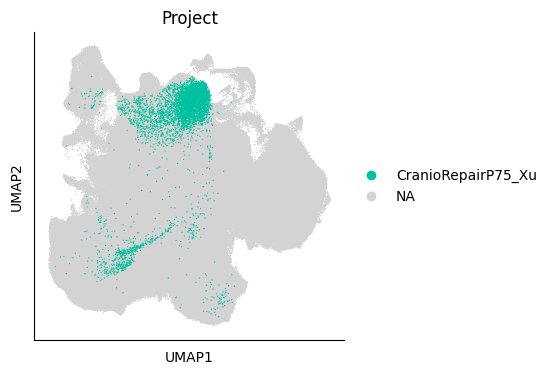

In [366]:
sc.pl.umap(extendAtlas,color=["Project"],groups="CranioRepairP75_Xu",size=3)

/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


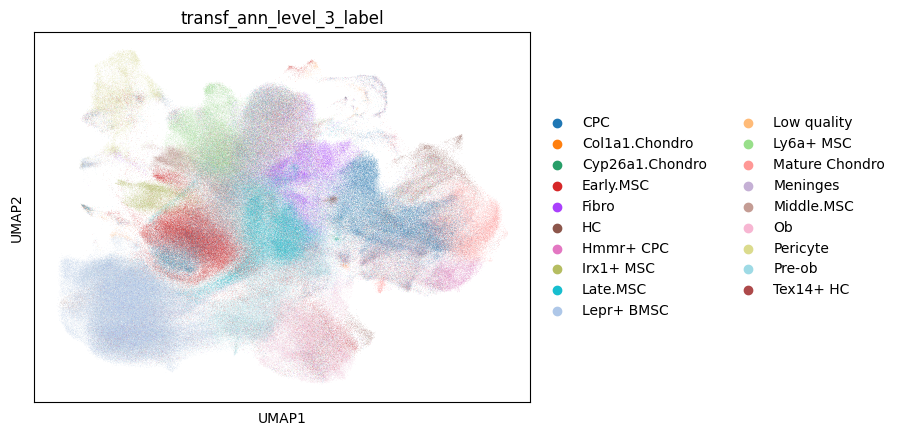

In [343]:
sc.pl.umap(extendAtlas,color=["transf_ann_level_3_label"])

In [381]:
np.sum(np.array(labels['lineage_chondro']|labels['lineage_laFibro'] | labels['lineage_lepr'] |labels['lineage_mesenchyme'] ))

430556

In [383]:
extendAtlas.obs["lineage"]=labels['lineage_chondro']|labels['lineage_laFibro'] | labels['lineage_lepr'] |labels['lineage_mesenchyme'] 

In [385]:
reflatent3.obs["lineage"]=extendAtlas.obs["lineage"]

In [386]:
reflatent3

AnnData object with n_obs × n_vars = 781397 × 15
    obs: 'Sample', 'Project', 'Core Dataset', 'Limb Atlas', 'Cranial Atlas', 'Organ', 'Tissue', 'Tissue(Specific)', 'Stage', 'Gene type', 'Treatment', 'Age', 'Age(In Detail)', 'Machine', 'Species', 'Isolation approach', 'Digestion', 'Enzymes', 'Cre', 'Bone Forming Methods', 'Data Source', 'Related Assay', 'Cell Count After QC', 'Origin', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'nCount_originalexp', 'nFeature_originalexp', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'batch', '_scvi_batch', 'scanvi_label', '_scvi_labels', 'leiden', 'pred_anno', 'reject', 'pred_anno7', 'pred_anno19', 'pred_anno36', 'pred_anno49', 'pred_anno90', 'leiden_clusters_0.001', 'leiden_clusters_0.005', 'leide

In [387]:
extendAtlas

AnnData object with n_obs × n_vars = 781397 × 20664
    obs: 'Sample', 'Project', 'Core Dataset', 'Limb Atlas', 'Cranial Atlas', 'Organ', 'Tissue', 'Tissue(Specific)', 'Stage', 'Gene type', 'Treatment', 'Age', 'Age(In Detail)', 'Machine', 'Species', 'Isolation approach', 'Digestion', 'Enzymes', 'Cre', 'Bone Forming Methods', 'Data Source', 'Related Assay', 'Cell Count After QC', 'Origin', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'nCount_originalexp', 'nFeature_originalexp', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'batch', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'transf_ann_level_7_label', 'transf_ann_level_6_label', 'transf_ann_level_5_label', 'transf_ann_level_4_label', 'transf_ann_level_

In [388]:
reflatent3.obs[['lineage_chondro', 'lineage_laFibro', 'lineage_lepr', 'lineage_mesenchyme', 'dpt_pred']]=extendAtlas.obs[['lineage_chondro', 'lineage_laFibro', 'lineage_lepr', 'lineage_mesenchyme', 'dpt_pred']]

In [389]:
reflatent3

AnnData object with n_obs × n_vars = 781397 × 15
    obs: 'Sample', 'Project', 'Core Dataset', 'Limb Atlas', 'Cranial Atlas', 'Organ', 'Tissue', 'Tissue(Specific)', 'Stage', 'Gene type', 'Treatment', 'Age', 'Age(In Detail)', 'Machine', 'Species', 'Isolation approach', 'Digestion', 'Enzymes', 'Cre', 'Bone Forming Methods', 'Data Source', 'Related Assay', 'Cell Count After QC', 'Origin', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'nCount_originalexp', 'nFeature_originalexp', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'batch', '_scvi_batch', 'scanvi_label', '_scvi_labels', 'leiden', 'pred_anno', 'reject', 'pred_anno7', 'pred_anno19', 'pred_anno36', 'pred_anno49', 'pred_anno90', 'leiden_clusters_0.001', 'leiden_clusters_0.005', 'leide

In [390]:
refSub=reflatent3[reflatent3.obs["lineage"]]

In [397]:
extendAtlas.obs["lineage_str"]=extendAtlas.obs["lineage"].astype("str")

/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


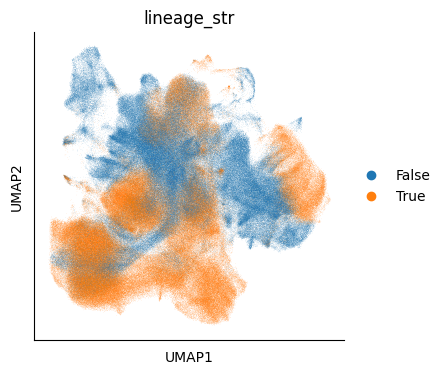

In [398]:
sc.pl.umap(extendAtlas,color=["lineage_str"])

/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


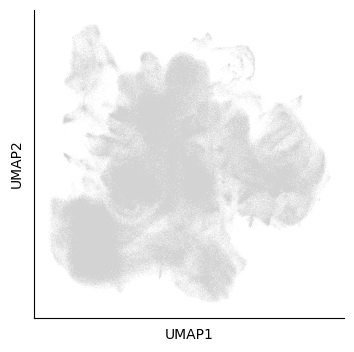

In [393]:
sc.pl.umap(reflatent3)

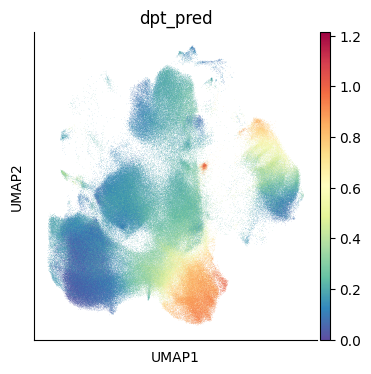

In [401]:
sc.pl.umap(refSub,color="dpt_pred",vmin=0)

In [402]:
refSub.write_h5ad("../../important_processed_data/24.1.6_reflatendLineage.h5ad")

In [404]:
sc.tl.umap(refSub)
sc.tl.draw_graph(refSub)

/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/si

In [461]:
refSub

AnnData object with n_obs × n_vars = 430556 × 15
    obs: 'Sample', 'Project', 'Core Dataset', 'Limb Atlas', 'Cranial Atlas', 'Organ', 'Tissue', 'Tissue(Specific)', 'Stage', 'Gene type', 'Treatment', 'Age', 'Age(In Detail)', 'Machine', 'Species', 'Isolation approach', 'Digestion', 'Enzymes', 'Cre', 'Bone Forming Methods', 'Data Source', 'Related Assay', 'Cell Count After QC', 'Origin', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'nCount_originalexp', 'nFeature_originalexp', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'batch', '_scvi_batch', 'scanvi_label', '_scvi_labels', 'leiden', 'pred_anno', 'reject', 'pred_anno7', 'pred_anno19', 'pred_anno36', 'pred_anno49', 'pred_anno90', 'leiden_clusters_0.001', 'leiden_clusters_0.005', 'leide